In [2]:
from fastjet_contribs import compute_nsubjettiness, apply_soft_drop

In [3]:
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils import scatter

In [4]:
data = ef.zjets_delphes.load("Herwig", num_data=100000, pad=True, cache_dir='/remote/gpu04/petitjean/high-dim-unfolding/data/zplusjet',
                                       source='zenodo', which='all',
                                       include_keys=None, exclude_keys=None)

In [5]:
def handle_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [6]:
det_jets = data['sim_jets'][:, np.newaxis, :]
det_particles = data['sim_particles']
det_particles[..., 0] = det_particles[..., 0] * 100
det_particles[..., 1:3] = det_particles[..., 1:3] + det_jets[..., 1:3]
det_particles[..., 2] = handle_angle(det_particles[..., 2])
det_mults = data['sim_mults']
gen_jets = data['gen_jets'][:, np.newaxis, :]
gen_particles = data['gen_particles']
gen_particles[..., 0] = gen_particles[..., 0] * 100
gen_particles[...,1:3] = gen_particles[..., 1:3] + gen_jets[..., 1:3]
gen_particles[..., 2] = handle_angle(gen_particles[..., 2])
gen_mults = data['gen_mults']
gen_tau1s = data['gen_widths']
det_tau1s = data['sim_widths']
gen_tau2s = data['gen_tau2s']
det_tau2s = data['sim_tau2s']
gen_sdms = data['gen_sdms']
det_sdms = data['sim_sdms']
gen_zgs = data['gen_zgs']
det_zgs = data['sim_zgs']

In [7]:
print(det_jets[..., 0].shape)
print(det_mults.shape)

(100000, 1)
(100000,)


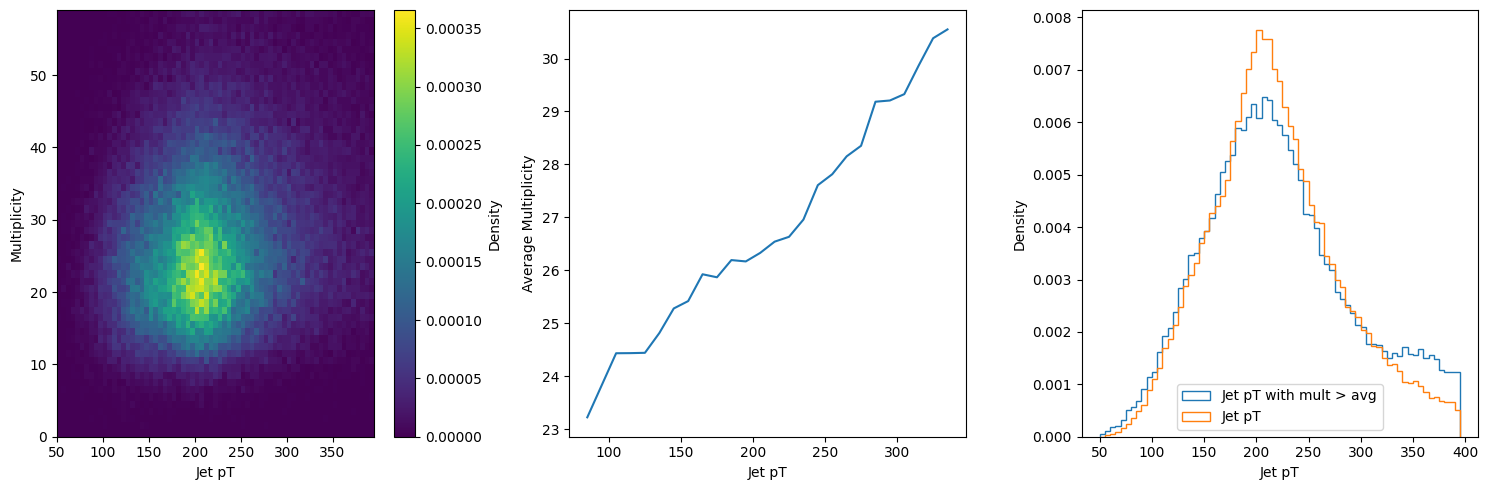

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(131)
hist2d = plt.hist2d(gen_jets[...,0].squeeze(), gen_mults, bins=(np.arange(50, 400, 5), np.arange(0, 60, 1)), density=True)
plt.xlabel('Jet pT')
plt.ylabel('Multiplicity')
plt.colorbar(hist2d[3], label='Density')

plt.subplot(132)
pt_bins = np.arange(80, 350, 10)
pt_centers = (pt_bins[:-1] + pt_bins[1:])/2

avg_mults = []
for i in range(len(pt_bins)-1):
    mask = (gen_jets[...,0].squeeze() >= pt_bins[i]) & (gen_jets[...,0].squeeze() < pt_bins[i+1])
    avg_mults.append(np.mean(gen_mults[mask]))

plt.plot(pt_centers, avg_mults)
plt.xlabel('Jet pT')
plt.ylabel('Average Multiplicity')

plt.subplot(133)
mult_threshold = np.zeros_like(gen_jets[...,0].squeeze())
for i in range(len(pt_bins)-1):
    bin_mask = (gen_jets[...,0].squeeze() >= pt_bins[i]) & (gen_jets[...,0].squeeze() < pt_bins[i+1])
    mult_threshold[bin_mask] = avg_mults[i]
mask = gen_mults > mult_threshold
plt.hist(det_jets[...,0].squeeze()[mask], bins=np.arange(50, 400, 5), label='Jet pT with mult > avg', density=True, histtype='step')
plt.hist(gen_jets[...,0].squeeze(), bins=np.arange(50, 400, 5), label='Jet pT', density=True, histtype='step')
plt.xlabel('Jet pT')
plt.ylabel(f'Density')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
def jetmomenta_to_fourmomenta(jetmomenta):
    pt, eta, phi, mass = np.transpose(jetmomenta, axes=(2, 0, 1))

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(mass**2 + px**2 + py**2 + pz**2)

    fourmomenta = np.stack((E, px, py, pz), axis=-1)
    return fourmomenta

In [7]:
pid_to_mass = {
    0.0: 0.0,      # Photon (PID 22)
    0.1: 0.139570, # π⁺ (PID 211)
    0.2: 0.139570, # π⁻ (PID -211)
    0.3: 0.497614, # K⁰_L (PID 130)
    0.4: 0.000511, # Electron (PID 11)
    0.5: 0.000511, # Positron (PID -11)
    0.6: 0.105658, # μ⁺ (PID 13)
    0.7: 0.105658, # μ⁻ (PID -13)
    0.8: 0.493677, # K⁺ (PID 321)
    0.9: 0.493677, # K⁻ (PID -321)
    1.0: 0.938272, # Proton (PID 2212)
    1.1: 0.938272, # Antiproton (PID -2212)
    1.2: 0.939565, # Neutron (PID 2112)
    1.3: 0.939565  # Antineutron (PID -2112)
}

In [8]:
gen_particles[..., 3] = np.vectorize(pid_to_mass.get)(gen_particles[..., 3])

In [9]:
gen_particles = jetmomenta_to_fourmomenta(gen_particles)

In [10]:
i = 2

In [11]:
gen_particles.shape

(100000, 116, 4)

In [12]:
for i in range(10):
    px, py, pz, E, zg = apply_soft_drop(gen_particles[i, :gen_mults[i]][:, [1,2,3,0]], beta=0.0, zcut=0.1, R0=0.8)
    m = np.sqrt(abs(E**2 - px**2 - py**2 - pz**2))
    print(f"Soft drop mass: {m}, zg: {zg}")
    print(f"True soft drop mass: {gen_sdms[i]}, true zg: {gen_zgs[i]}")

Soft drop mass: 18.325122744078495, zg: 0.12454118804116851
True soft drop mass: 12.10161023844734, true zg: 0.12500462508533602
Soft drop mass: 2.257070863531128, zg: 0.23593446852072775
True soft drop mass: 2.258511785972451, true zg: 0.23593446852072775
Soft drop mass: 27.96483325391534, zg: 0.2961349610425271
True soft drop mass: 27.99105519031225, true zg: 0.29613496104252707
Soft drop mass: 23.983306497962243, zg: 0.13112391901973638
True soft drop mass: 23.877188414897656, true zg: 0.13112391901973636
#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this packa

In [13]:
tau1 = np.array([compute_nsubjettiness(gen_particles[i][..., [1,2,3,0]], N=1, beta=1.0,R0=0.4, axis_mode=3) for i in range(100)])
tau2 = np.array([compute_nsubjettiness(gen_particles[i][..., [1,2,3,0]], N=2, beta=1.0,R0=0.4, axis_mode=3) for i in range(100)])

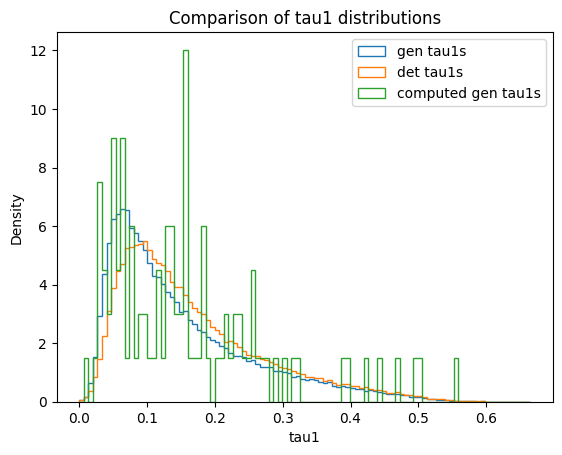

In [14]:

_, bins = np.histogram(gen_tau1s, bins=100)
plt.hist(gen_tau1s, bins=bins, label='gen tau1s', histtype='step', density=True)
plt.hist(det_tau1s, bins=bins, label='det tau1s', histtype='step', density=True)
plt.hist(tau1, bins=bins, label='computed gen tau1s', histtype='step', density=True)
plt.title('Comparison of tau1 distributions')
plt.xlabel('tau1')
plt.ylabel('Density')
plt.legend()
plt.show()

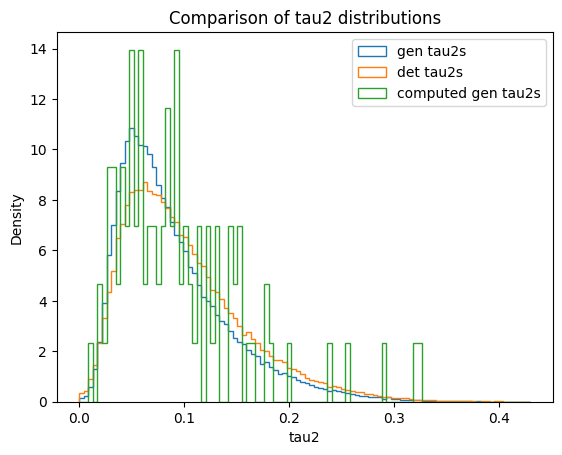

In [15]:

_, bins = np.histogram(gen_tau2s, bins=100)
plt.hist(gen_tau2s, bins=bins, label='gen tau2s', histtype='step', density=True)
plt.hist(det_tau2s, bins=bins, label='det tau2s', histtype='step', density=True)
plt.hist(tau2, bins=bins, label='computed gen tau2s', histtype='step', density=True)
plt.title('Comparison of tau2 distributions')
plt.xlabel('tau2')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipykernel_56248/234108136.py:1: RuntimeWarning: invalid value encountered in divide
  gen_t21 = np.where(gen_tau1s < 0.001, 0, gen_tau2s / gen_tau1s)
/tmp/ipykernel_56248/234108136.py:2: RuntimeWarning: invalid value encountered in divide
  det_t21 = np.where(det_tau1s < 0.001, 0, det_tau2s / det_tau1s)


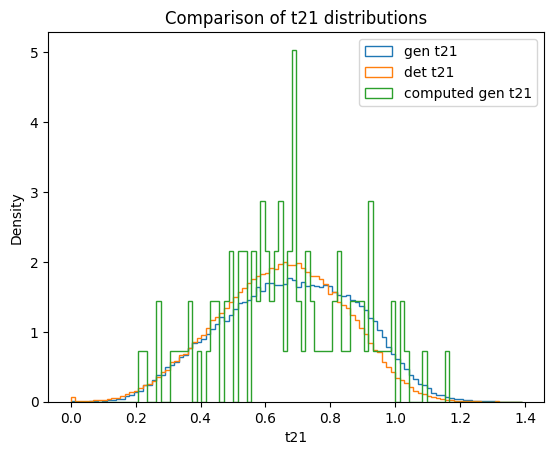

In [16]:
gen_t21 = np.where(gen_tau1s < 0.001, 0, gen_tau2s / gen_tau1s)
det_t21 = np.where(det_tau1s < 0.001, 0, det_tau2s / det_tau1s)
t21 = np.where(tau1 < 0.001, 0, tau2 / tau1)
_, bins = np.histogram(gen_t21, bins=100)
plt.hist(gen_t21, bins=bins, label='gen t21', histtype='step', density=True)
plt.hist(det_t21, bins=bins, label='det t21', histtype='step', density=True)
plt.hist(t21, bins=bins, label='computed gen t21', histtype='step', density=True)
plt.title('Comparison of t21 distributions')
plt.xlabel('t21')
plt.ylabel('Density')
plt.legend()
plt.show()

In [17]:
det_mask = np.arange(det_particles.shape[1])[None, :] < det_mults[:, None]
gen_mask = np.arange(gen_particles.shape[1])[None, :] < gen_mults[:, None]

In [18]:
def nth_largest_pt_mask(particles, n):
    """
    Returns a boolean mask to extract the particle with the n-th largest pt on axis 1.
    
    Args:
    particles: numpy array of shape (num_events, num_particles, 4)
    n: int, the rank of pt to select (1 for largest, 2 for second largest, etc.)
    
    Returns:
    mask: boolean numpy array of the same shape as particles
    """
    pt = particles[..., 0]
    rank = pt.argsort(axis=1)
    nth_largest_indices = rank[:, -n]
    mask = np.zeros_like(pt, dtype=bool)
    mask[np.arange(len(mask)), nth_largest_indices] = True
    return mask

In [19]:
det_jets[..., 2] = handle_angle(det_jets[..., 2])
det_jets = det_jets.squeeze()
flattened_det_particles = det_particles[det_mask]
gen_jets[..., 2] = handle_angle(gen_jets[..., 2])
gen_jets = gen_jets.squeeze()
flattened_gen_particles = gen_particles[gen_mask]

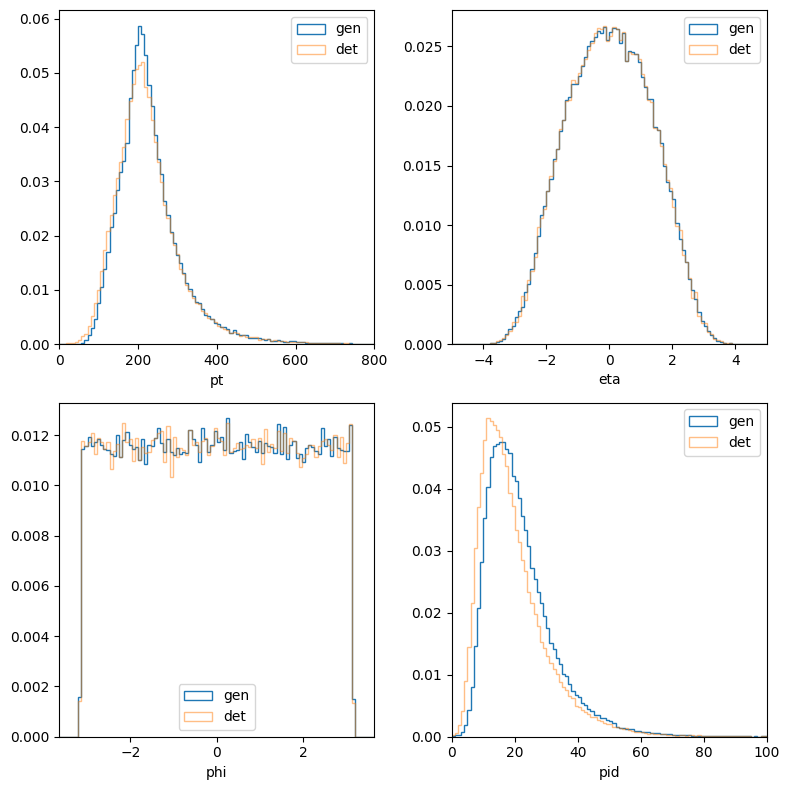

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['pt', 'eta', 'phi', 'pid']
x_limits = [(0, 800), (-5, 5), (-np.pi - 0.5, np.pi + 0.5), (0, 100)]
for i, ax in enumerate(ax.flatten()):
    
    gen_hist, bins = np.histogram(gen_jets[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_jets[:, i], bins=bins)

    gen_hist = gen_hist / len(gen_jets)
    det_hist = det_hist / len(det_jets)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step', alpha=0.5)
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    ax.legend()
fig.tight_layout()
plt.show()

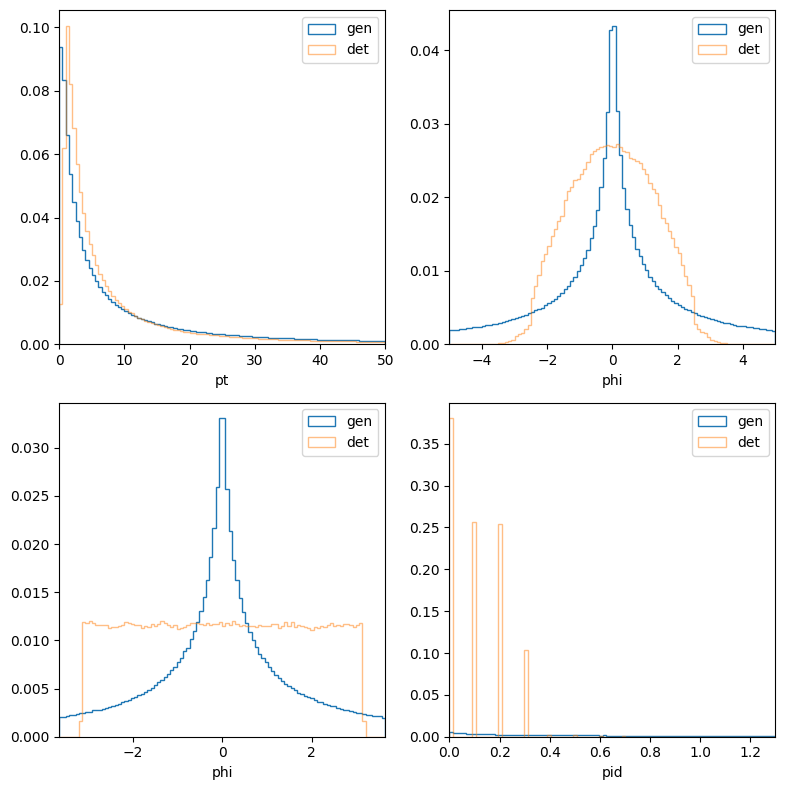

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['pt', 'phi', 'phi', 'pid']
x_limits = [(0, 50), (-5, 5), (-np.pi - 0.5, np.pi + 0.5), (0, 1.3)]
for i, ax in enumerate(ax.flatten()):
    
    gen_hist, bins = np.histogram(flattened_gen_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(flattened_det_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / len(flattened_gen_particles)
    det_hist = det_hist / len(flattened_det_particles)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step', alpha=0.5)
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    ax.legend()
fig.tight_layout()
plt.show()

In [22]:
MASS = 0.1
flattened_det_particles[..., -1] = MASS
flattened_gen_particles[..., -1] = MASS

In [23]:
det_fourmomenta = jetmomenta_to_fourmomenta(flattened_det_particles)
det_jets_fourmomenta = jetmomenta_to_fourmomenta(det_jets)
gen_fourmomenta = jetmomenta_to_fourmomenta(flattened_gen_particles)
gen_jets_fourmomenta = jetmomenta_to_fourmomenta(gen_jets)

ValueError: axes don't match array

In [ ]:
def get_batch_from_ptr(ptr):
    return torch.arange(len(ptr) - 1, device=ptr.device).repeat_interleave(
        ptr[1:] - ptr[:-1],
    )

In [ ]:
gen_ptr = np.insert(np.cumsum(gen_mults), 0, 0)
gen_batch = get_batch_from_ptr(torch.tensor(gen_ptr))
det_ptr = np.insert(np.cumsum(det_mults), 0, 0)
det_batch = get_batch_from_ptr(torch.tensor(det_ptr))

In [ ]:
agg_gen_fourmomenta = scatter(torch.tensor(gen_fourmomenta), index=gen_batch, dim=0, reduce="sum")
agg_det_fourmomenta = scatter(torch.tensor(det_fourmomenta), index=det_batch, dim=0, reduce='sum')

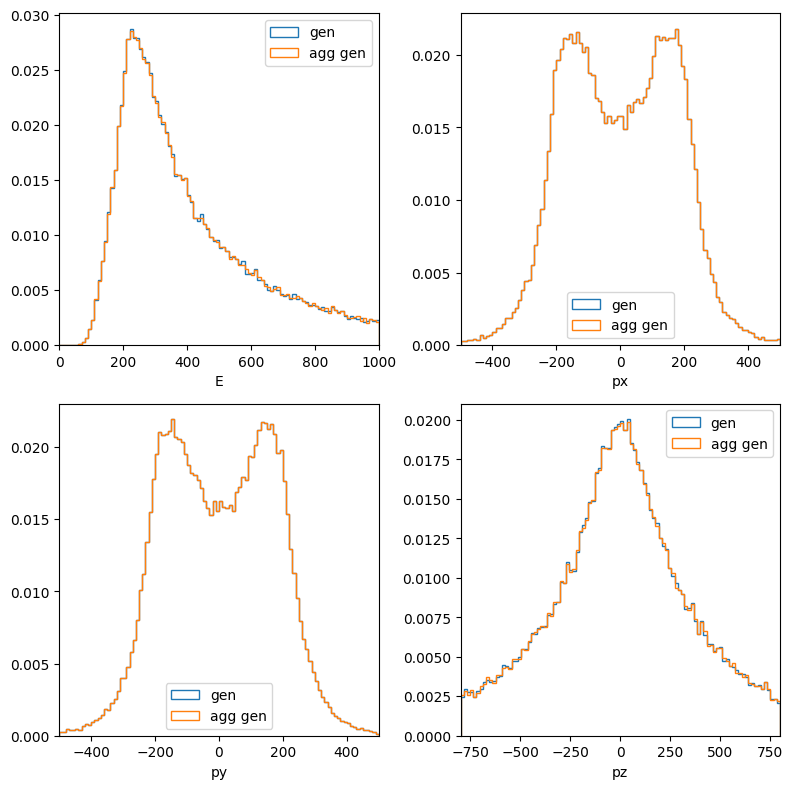

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 1000), (-500,500), (-500,500), (-800,800)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_jets_fourmomenta[:, i], bins=100, range=x_limits[i])
    agg_gen_hist, _ = np.histogram(agg_gen_fourmomenta[:, i], bins=bins)
    det_hist, _ = np.histogram(det_jets_fourmomenta[:, i], bins=bins)
    agg_det_hist, _ = np.histogram(agg_det_fourmomenta[:, i], bins=bins)
    
    gen_hist = gen_hist / len(gen_jets_fourmomenta)
    agg_gen_hist = agg_gen_hist / len(agg_gen_fourmomenta)
    det_hist = det_hist / len(det_jets_fourmomenta)
    agg_det_hist = agg_det_hist / len(agg_det_fourmomenta)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=agg_gen_hist, label='agg gen', histtype='step')
    # ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    # ax.hist(bins[:-1], bins=bins, weights=agg_det_hist, label='agg det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

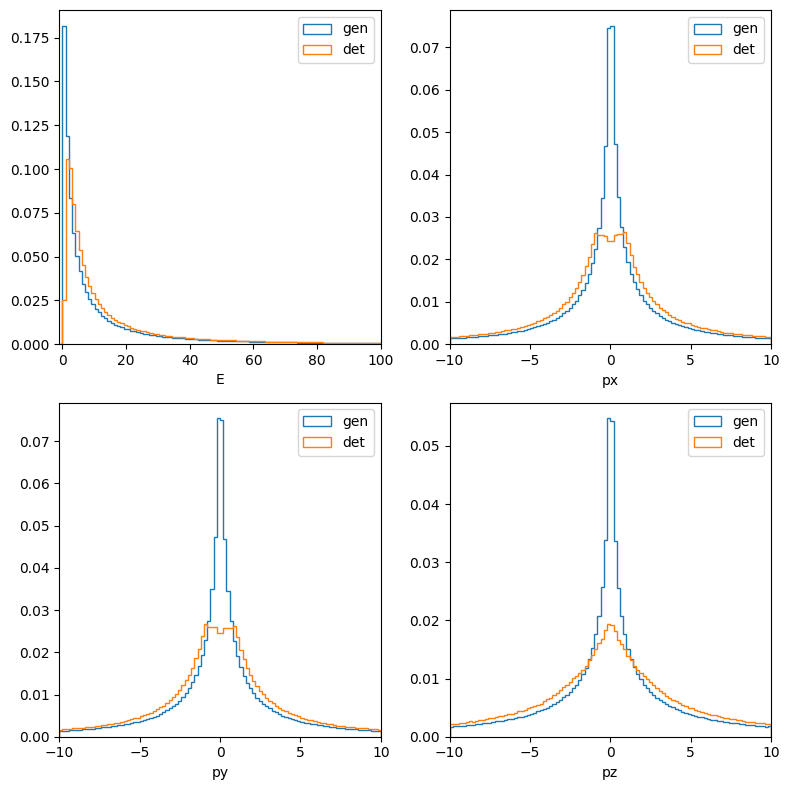

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(-1, 100), (-10, 10), (-10, 10), (-10, 10)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_fourmomenta[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_fourmomenta[:, i], bins=bins)
    
    gen_hist = gen_hist / len(gen_fourmomenta)
    det_hist = det_hist / len(det_fourmomenta)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
n = 2

In [ ]:
det_pt_mask = nth_largest_pt_mask(det_particles, n)
gen_pt_mask = nth_largest_pt_mask(gen_particles, n)

In [ ]:
det_first_particles = jetmomenta_to_fourmomenta(det_particles[det_pt_mask])
gen_first_particles = jetmomenta_to_fourmomenta(gen_particles[gen_pt_mask])

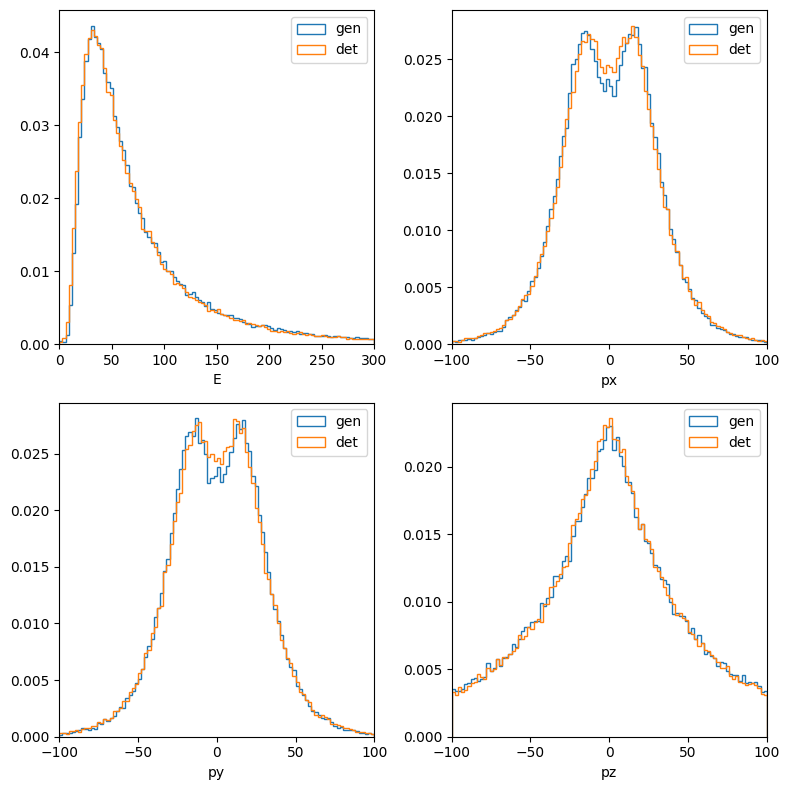

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
x_limits = [(0, 300), (-100, 100), (-100, 100), (-100, 100)]
for i, ax in enumerate(ax.flatten()):
    gen_hist, bins = np.histogram(gen_first_particles[:, i], bins=100, range=x_limits[i])
    det_hist, _ = np.histogram(det_first_particles[:, i], bins=bins)
    
    gen_hist = gen_hist / np.sum(gen_hist)
    det_hist = det_hist / np.sum(det_hist)
    
    ax.hist(bins[:-1], bins=bins, weights=gen_hist, label='gen', histtype='step')
    ax.hist(bins[:-1], bins=bins, weights=det_hist, label='det', histtype='step')
    ax.set_xlabel(labels[i])
    ax.set_xlim(x_limits[i])
    
    ax.legend()
fig.tight_layout()
plt.show()

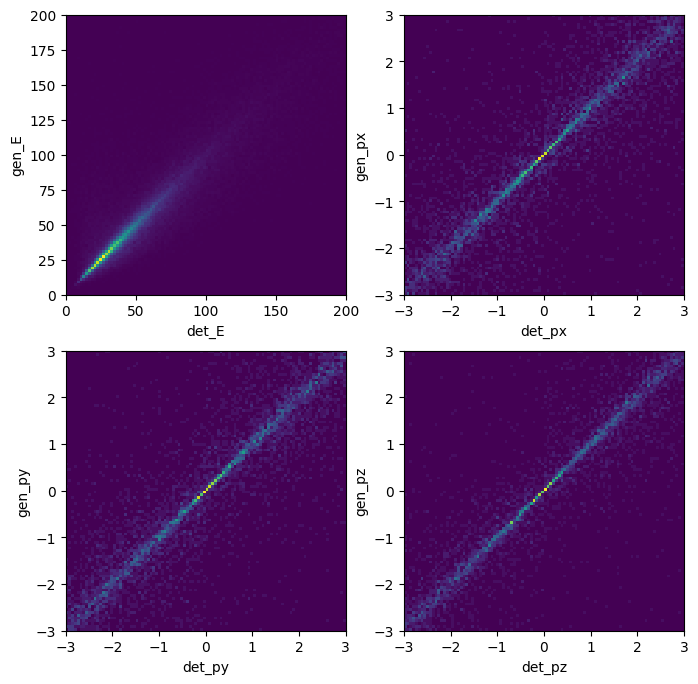

In [ ]:
ig, ax = plt.subplots(2, 2, figsize=(8, 8))
labels = ['E', 'px', 'py', 'pz']
ax_limits = [(0, 200), (-3,3), (-3, 3), (-3, 3)]
for i, ax in enumerate(ax.flatten()):
    ax.hist2d(det_first_particles[:, i], gen_first_particles[:, i], bins=100, range = (ax_limits[i], ax_limits[i]))
    ax.set_xlabel('det_'+labels[i])
    ax.set_ylabel('gen_'+labels[i])
    ax.set_aspect('equal')
    ax.set_xlim(ax_limits[i])
    ax.set_ylim(ax_limits[i])
fig.tight_layout()
plt.show()